In [42]:
import sys
import torch  
import numpy as np  
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from torch.distributions.categorical import Categorical
import math
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from preprocess import mean, std, preprocess_input_function
from settings import train_dir, test_dir, train_push_dir, train_batch_size, test_batch_size, train_push_batch_size
from settings import base_architecture, img_size, prototype_shape, num_classes, prototype_activation_function, add_on_layers_type
from receptive_field import compute_rf_prototype
import cv2
#from reward_model import construct_PrefNet, paired_cross_entropy_loss, PrefNet
from tqdm import tqdm
from settings import joint_optimizer_lrs, joint_lr_step_size
import skimage as sk
import skimage.io as skio
import train_and_test as tnt
from torch.utils.data import Subset
import time
import heapq

In [43]:
'''
Use PPnet's forward pass as the policy network (actor network); what about the network for value function (critic network)?
Since there are only determinant actions, this is essentially A2C...
'''
class A3C_PPnet(nn.Module):
    def __init__(self, PPnet, preference_model, k=1, p=5, learning_rate=1e-4, dummy_reward=False, train_batch_size=80):
        super(A3C_PPnet, self).__init__()
        
        
        self.PPnet = PPnet.cuda()
        self.k = k
        self.pf_model = preference_model.cuda()
        
        self.PPnet_multi = self.PPnet
        for p in self.PPnet_multi.module.features.parameters():
            p.requires_grad = False
        for p in self.PPnet_multi.module.add_on_layers.parameters():
            p.requires_grad = False
        self.PPnet_multi.module.prototype_vectors.requires_grad = True
        for p in self.PPnet_multi.module.last_layer.parameters():
            p.requires_grad = False
        
        self.train_batch_size = train_batch_size
        self.num_epoch = 0
        policy_optimizer_specs = [#{'params': self.PPnet.features.parameters(), 'lr': joint_optimizer_lrs['features'], 'weight_decay': 1e-3}, 
                                  #{'params': self.PPnet.add_on_layers.parameters(), 'lr': joint_optimizer_lrs['add_on_layers'], 'weight_decay': 1e-3},
                                  #{'params': self.PPnet.prototype_vectors, 'lr': joint_optimizer_lrs['prototype_vectors']},
                                  #{'params': self.PPnet.module.add_on_layers.parameters(), 'lr': 1e-4, 'weight_decay': 1e-5},
                                  {'params': self.PPnet.module.prototype_vectors, 'lr': 1e-3, 'weight_decay': 1e-4}
                                  ]
        self.policy_optimizer = torch.optim.Adam(policy_optimizer_specs)
        self.num_iteration = 0
        
        
    def get_heatmaps(self, batch_x, labels, pid):
        self.PPnet_multi.eval()
        n_prototypes = self.PPnet_multi.module.num_prototypes
        prototype_shape = self.PPnet_multi.module.prototype_shape
        max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]
        protoL_rf_info = self.PPnet_multi.module.proto_layer_rf_info
        
        batch_x = batch_x.cuda()
        protoL_input_torch, proto_dist_torch = self.PPnet_multi.module.push_forward(batch_x)
        
        proto_dist_ = proto_dist_torch.view(proto_dist_torch.shape[0], proto_dist_torch.shape[1], -1)
        # proto_dist_: (batch_size, 1000, 49)
        all_distances = torch.amin(proto_dist_, axis=-1)
        # all_distances: (batch_size, 1000)
        target_p = [pid]
        #for i in range(all_distances.shape[1]):
        #    class_i = torch.argmax(self.PPnet_multi.module.prototype_class_identity[i])
        #    if class_i == class_identity:
        #        target_p.append(i)
        
        proto_dist = torch.clone(proto_dist_torch)
       
        proto_dist = torch.transpose(proto_dist, 0, 1)
        dists = all_distances[:, target_p]
        dists = torch.transpose(dists, 0, 1)
        
    
        # proto_dist: (1000, batch_size)
        proto_dist_numpy = proto_dist.detach().cpu().numpy()
        
        
        original_imgs = []
        rescaled_patterns = []
        
        for j in target_p:
            
            original_imgs_j = []
            rescaled_patterns_j = []
           
            for i in range(len(batch_x)):
                closest_patch_indices_in_distance_map_j = list(np.unravel_index(np.argmin(proto_dist_numpy[j][i],axis=None), proto_dist_numpy[j][i].shape))
                closest_patch_indices_in_distance_map_j = [0] + closest_patch_indices_in_distance_map_j
                
                closest_patch_indices_in_img = compute_rf_prototype(batch_x.size(2), closest_patch_indices_in_distance_map_j, protoL_rf_info)
                closest_patch = \
                    batch_x[i, :, closest_patch_indices_in_img[1]:closest_patch_indices_in_img[2], closest_patch_indices_in_img[3]:closest_patch_indices_in_img[4]]
                closest_patch = closest_patch.cpu().numpy()
                closest_patch = np.transpose(closest_patch, (1, 2, 0))

                original_img = batch_x[i].cpu().numpy()
                original_img = np.transpose(original_img, (1, 2, 0))
                
                
                if self.PPnet_multi.module.prototype_activation_function == 'log':
                    act_pattern = np.log((proto_dist_numpy[j][i] + 1)/(proto_dist_numpy[j][i] + self.PPnet_multi.module.epsilon))
                elif self.PPnet_multi.module.prototype_activation_function == 'linear':
                    act_pattern = max_dist - proto_dist_numpy[j][i]
                else:
                    act_pattern = prototype_activation_function_in_numpy(proto_dist_numpy[j][i])

                patch_indices = closest_patch_indices_in_img[1:5]
                          
                upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
                rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
                rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
                
                original_img = original_img - np.amin(original_img)
                original_img = original_img / np.amax(original_img)
                original_imgs_j.append(original_img)
                rescaled_patterns_j.append(rescaled_act_pattern)
                
            
            original_imgs.append(original_imgs_j)
            rescaled_patterns.append(rescaled_patterns_j)
    
        return original_imgs, rescaled_patterns, dists
    
    '''
    imgs: (1000, 1, 224, 224, 3), patterns: (1000, 1, 224, 224)
    '''
    def get_rewards(self, imgs, patterns):
        
        num_p = len(imgs)
        assert num_p == len(patterns)
        batch_size = len(imgs[0])
        assert batch_size == len(patterns[0])
        
        with torch.no_grad():
            rewards = torch.empty((num_p, batch_size))
            for i in range(num_p):
                for j in range(batch_size):
                    img = np.array([imgs[i][j]])
                    img = np.transpose(img, (0, 3, 1, 2))
                    img = torch.from_numpy(img).cuda()
                
                    pattern = patterns[i][j]
                    pattern = np.array([pattern, pattern, pattern])
                    pattern = torch.from_numpy(np.array([pattern])).cuda()
                    reward = self.pf_model(img, pattern) 
                    rewards[i][j] = reward
                
        return rewards
        
    def joint_update(self, rewards, dists):
        #print(dists)
        
        assert rewards.shape[0] == len(dists)
        assert rewards.shape[1] == len(dists[0])
        
        self.policy_optimizer.zero_grad()
        loss = 0
        for i in range(rewards.shape[0]):
            for j in range(rewards.shape[1]):
                if dists[i][j] > 0:
                    loss -= (1 / (100*dists[i][j]+1)) * rewards[i][j]
                #elif dists[i][j] == 0:
                #    loss -= rewards[i][j]
        
        loss.backward()
        self.policy_optimizer.step()
        return 
    
    
    def run(self, batch_x, labels, pid, update=True):

        original_imgs, rescaled_patterns, dists = self.get_heatmaps(batch_x, labels, pid)
        rewards = self.get_rewards(original_imgs, rescaled_patterns)
        if update:
            loss = self.joint_update(rewards, dists)
        
        
        
        return torch.mean(rewards)
   
    

In [44]:
def reselect_prototypes(a3c, update_threshold, select_threshold, bad_prototype_idx):
    # get the heatmaps by searching for the closest images in the entire dataset
    # can use different k values
    # heatmaps: (1000, 1, 224, 224, 3)
    # rewards: (1000,)
    # patch_ids: (1000, 3, (idx tuple))
    prototype_shape = a3c.PPnet_multi.module.prototype_shape
    
    initial_bad_rewards = []
    final_bad_rewards = []
    '''
    rewards = a3c.get_rewards(original_imgs, patterns)
    for i in range(len(rewards)):
        if rewards[i] < update_threshold:
            bad_prototype_idx.append(i)
            initial_bad_rewards.append(rewards[i])
    print("bad prototype number: ", len(bad_prototype_idx))
    print("initial mean bad reward: ", torch.mean(torch.tensor(initial_bad_rewards)))
    '''

    
    patch_ids = []
    failed_p = []
    #patch_ids = [patch_id[0] for patch_id in patch_ids]
    # patch_ids: (1000, tuple), where tuple := (img_idx, h, w)

    success_count = 0
    # loop over each prototype
    for k in tqdm(range(len(bad_prototype_idx))):
        j = bad_prototype_idx[k]
        a3c.PPnet_multi.eval()
        n_prototypes = a3c.PPnet_multi.module.num_prototypes
        prototype_shape = a3c.PPnet_multi.module.prototype_shape
        max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]
        protoL_rf_info = a3c.PPnet_multi.module.proto_layer_rf_info
        class_identity = torch.argmax(a3c.PPnet_multi.module.prototype_class_identity[j])
        class_idx = [x for x, y in enumerate(train_dataset.targets) if y == class_identity]
        class_start_idx = class_idx[0]
        class_dataset = Subset(train_dataset, class_idx)
        dataloader = torch.utils.data.DataLoader(class_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=False)
        batch_x, label = next(iter(dataloader))
        batch_x = batch_x.cuda()
        with torch.no_grad():
            initial_reward = a3c.run(batch_x, label, j, update=False)
        
        
        initial_bad_rewards.append(initial_reward.detach().cpu().numpy())
        # conv_outs: (80, 128, 7, 7)
        conv_outs = a3c.PPnet_multi.module.conv_features(batch_x)
        batch_idx = np.arange(batch_x.shape[0])
        class_idx_batch = batch_idx[label == class_identity]
        #print(class_idx_batch)
        class_outs = conv_outs[label == class_identity]
        if class_outs.shape[0] == 0:
            continue
        height = class_outs.shape[2]
        width = class_outs.shape[3]
        success = False
        for _ in range(500):
            img_idx = np.random.choice(class_outs.shape[0])
            h = np.random.choice(height)
            w = np.random.choice(width)
            
            patch_candidate = class_outs[img_idx, :, h:h+1, w:w+1]
            a3c.PPnet_multi.module.prototype_vectors.data[j] = patch_candidate
            #a3c.PPnet_multi.module.prototype_vectors.data.copy_(vec)
            # distances: (7, 7)
            with torch.no_grad():
                patch_reward = a3c.run(batch_x, label, j, update=False)
            '''
            distances = a3c.PPnet_multi.module._l2_convolution(class_outs[img_idx])[j].detach().cpu().numpy()

            if a3c.PPnet_multi.module.prototype_activation_function == 'log':
                act_pattern = np.log((distances + 1)/(distances + a3c.PPnet_multi.module.epsilon))
            elif a3c.PPnet_multi.module.prototype_activation_function == 'linear':
                act_pattern = max_dist - distances
            else:
                act_pattern = prototype_activation_function_in_numpy(distances)

            upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
            rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
            rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)

            img = torch.unsqueeze(batch_x[class_idx_batch[img_idx]], 0)
            pattern = torch.tensor(np.array([rescaled_act_pattern, rescaled_act_pattern, rescaled_act_pattern]))
            pattern = torch.unsqueeze(pattern, 0)

            patch_reward = a3c.pf_model(img, pattern.cuda()) 
            '''
            idx_tuple = (class_start_idx + img_idx, h, w)
            if patch_reward > select_threshold and idx_tuple not in patch_ids:
                patch_ids.append(idx_tuple)
                success = True
                success_count += 1
                break           
  
        if success:
            final_bad_rewards.append(patch_reward.detach().cpu().numpy())
        else:
            failed_p.append(j)
    print("bad prototype number: ", len(bad_prototype_idx))
    print("initial mean bad reward: ", np.mean(np.array(initial_bad_rewards)))
    print("final mean bad reward: ", np.mean(np.array(final_bad_rewards)))
    print("number of success: ", success_count)
    return final_bad_rewards, bad_prototype_idx, patch_ids, failed_p

In [45]:
from resnet_features import resnet18_features, resnet34_features, resnet50_features, resnet101_features, resnet152_features
from densenet_features import densenet121_features, densenet161_features, densenet169_features, densenet201_features
from vgg_features import vgg11_features, vgg11_bn_features, vgg13_features, vgg13_bn_features, vgg16_features, vgg16_bn_features,\
                         vgg19_features, vgg19_bn_features
from receptive_field import compute_proto_layer_rf_info_v2
base_architecture_to_features = {'resnet18': resnet18_features,
                                 'resnet34': resnet34_features,
                                 'resnet50': resnet50_features,
                                 'resnet101': resnet101_features,
                                 'resnet152': resnet152_features,
                                 'densenet121': densenet121_features,
                                 'densenet161': densenet161_features,
                                 'densenet169': densenet169_features,
                                 'densenet201': densenet201_features,
                                 'vgg11': vgg11_features,
                                 'vgg11_bn': vgg11_bn_features,
                                 'vgg13': vgg13_features,
                                 'vgg13_bn': vgg13_bn_features,
                                 'vgg16': vgg16_features,
                                 'vgg16_bn': vgg16_bn_features,
                                 'vgg19': vgg19_features,
                                 'vgg19_bn': vgg19_bn_features}


class PrefNet(nn.Module):

    def __init__(self, img_features, pattern_features, img_size, prototype_shape,
                 proto_layer_rf_info, num_classes, init_weights=False,
                 prototype_activation_function='log',
                 add_on_layers_type='bottleneck', 
                k = 1):

        super(PrefNet, self).__init__()
        self.img_size = img_size
        self.prototype_shape = prototype_shape
        self.num_prototypes = prototype_shape[0]
        self.num_classes = num_classes
        self.epsilon = 1e-4
        self.k = k
        
        # this has to be named features to allow the precise loading
        self.img_features = img_features
        self.pattern_features = pattern_features
        
                
#         self.prototype_vectors = nn.Parameter(torch.rand(self.prototype_shape),
#                                               requires_grad=True)

#         # do not make this just a tensor,
#         # since it will not be moved automatically to gpu
#         self.ones = nn.Parameter(torch.ones(self.prototype_shape),
#                                  requires_grad=False)

#         self.last_layer = nn.Linear(self.num_prototypes, self.num_classes,
#                                     bias=False) # do not use bias
    

        self.img_conv = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.pattern_conv = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.final_fc = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        
            )
        
        #self.fc1 = nn.Linear(6400, 512)
        #self.fc2 = nn.Linear(512, 32)
        #self.fc3 = nn.Linear(32, 1)
        #self.fc1 = nn.Linear(64, 16)
        

        if init_weights:
            self._initialize_weights()
            
            
    def conv_features(self, x):
        '''
        the feature input to prototype layer
        '''
        # Insert k and then img size
        x = self.features(x)
        #print("base features: ", x.shape)
        #x = self.add_on_layers(x)
        return x
    
    def forward(self, x, p):
        # (N, 512, 7, 7)
        #x = self.conv_features(x)
        x = self.img_features(x)
        #x = self.add_on_layers(x)
        x = self.img_conv(x)
        #print("conv out:", x.shape)
        p = self.pattern_features(p)
        #p = self.conv_features(p)
        #p = self.add_on_layers(p)
        p = self.pattern_conv(p)
        
        out = torch.cat((x, p), dim=1)
        #print("cat out shape: ", out.shape)
        out = torch.flatten(out, 1) 
        #print("flatten out shape: ", out.shape)
        
        out = self.final_fc(out)
        #out = torch.sigmoid(self.fc1(out))
        #out = torch.sigmoid(self.fc2(out))
        #out = self.fc3(out)
        return out

    
    def _initialize_weights(self):
        for m in self.img_conv.modules():
            if isinstance(m, nn.Conv2d):
                # every init technique has an underscore _ in the name
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        for m in self.pattern_conv.modules():
            if isinstance(m, nn.Conv2d):
                # every init technique has an underscore _ in the name
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)




            
def construct_PrefNet(base_architecture, pretrained=True, img_size=224,
                    prototype_shape=(1000, 128, 1, 1), num_classes=200,
                    prototype_activation_function='log',
                    add_on_layers_type='bottleneck',
                    k = 1):
    img_features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    pattern_features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    layer_filter_sizes, layer_strides, layer_paddings = img_features.conv_info()
    proto_layer_rf_info = compute_proto_layer_rf_info_v2(img_size=img_size,
                                                         layer_filter_sizes=layer_filter_sizes,
                                                         layer_strides=layer_strides,
                                                         layer_paddings=layer_paddings,
                                                         prototype_kernel_size=prototype_shape[2])
    return PrefNet(img_features=img_features,
                   pattern_features=pattern_features,
                 img_size=img_size,
                 prototype_shape=prototype_shape,
                 proto_layer_rf_info=proto_layer_rf_info,
                 num_classes=num_classes,
                 init_weights=True,
                 prototype_activation_function=prototype_activation_function,
                 add_on_layers_type=add_on_layers_type,
                 k = k)


def paired_cross_entropy_loss(out1, out2, targets):
    
    total_loss = 0
    for i in range(len(targets)):
        
        if targets[i] == -1:
            p1 = torch.exp(out1[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - torch.log(p1)
        elif targets[i] == 1:
            p2 = torch.exp(out2[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - torch.log(p2)

        else:
            p1 = torch.exp(out1[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            p2 = torch.exp(out2[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - (0.5*torch.log(p1) + 0.5*torch.log(p2))
            
        total_loss += loss
    return total_loss


In [46]:
class ImagePatch:

    def __init__(self, patch, label, distance,
                 original_img=None, act_pattern=None, patch_indices=None, img_id=None):
        self.patch = patch
        self.label = label
        self.negative_distance = -distance

        self.original_img = original_img
        self.act_pattern = act_pattern
        self.patch_indices = patch_indices
        self.img_id = img_id

    def __lt__(self, other):
        return self.negative_distance < other.negative_distance


class ImagePatchInfo:

    def __init__(self, label, distance):
        self.label = label
        self.negative_distance = -distance

    def __lt__(self, other):
        return self.negative_distance < other.negative_distance

def find_k_nearest_patches_to_prototypes(dataloader, # pytorch dataloader (must be unnormalized in [0,1])
                                         prototype_network_parallel, # pytorch network with prototype_vectors
                                         k=1,
                                         batch_size = 80,
                                         preprocess_input_function=None, # normalize if needed
                                         full_save=False, # save all the images
                                         root_dir_for_saving_images=None,
                                         log=print,
                                         prototype_activation_function_in_numpy=None, heatmap_ratio = 1.0):
    prototype_network_parallel.eval()
    '''
    full_save=False will only return the class identity of the closest
    patches, but it will not save anything.
    '''
    log('find nearest patches')
    start = time.time()
    n_prototypes = prototype_network_parallel.module.num_prototypes
    
    prototype_shape = prototype_network_parallel.module.prototype_shape
    max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]

    protoL_rf_info = prototype_network_parallel.module.proto_layer_rf_info

    heaps = []
    # allocate an array of n_prototypes number of heaps
    for _ in range(n_prototypes):
        # a heap in python is just a maintained list
        heaps.append([])

    for idx, (search_batch_input, search_y) in tqdm(enumerate(dataloader)):
        #print('batch {}'.format(idx))
        if preprocess_input_function is not None:
            # print('preprocessing input for pushing ...')
            # search_batch = copy.deepcopy(search_batch_input)
            search_batch = preprocess_input_function(search_batch_input)

        else:
            search_batch = search_batch_input

        with torch.no_grad():
            search_batch = search_batch.cuda()
            protoL_input_torch, proto_dist_torch = \
                prototype_network_parallel.module.push_forward(search_batch)

        #protoL_input_ = np.copy(protoL_input_torch.detach().cpu().numpy())
        proto_dist_ = np.copy(proto_dist_torch.detach().cpu().numpy())
        
        # proto_dist_: (80, 1000, 7, 7)

        for img_idx, distance_map in enumerate(proto_dist_):
            for j in range(n_prototypes):
                # find the closest patches in this batch to prototype j

                closest_patch_distance_to_prototype_j = np.amin(distance_map[j])



                closest_patch_indices_in_distance_map_j = \
                    list(np.unravel_index(np.argmin(distance_map[j],axis=None),
                                          distance_map[j].shape))
                patch_idx = closest_patch_indices_in_distance_map_j
                
                closest_patch_indices_in_distance_map_j = [0] + closest_patch_indices_in_distance_map_j
                closest_patch_indices_in_img = \
                    compute_rf_prototype(search_batch.size(2),
                                         closest_patch_indices_in_distance_map_j,
                                         protoL_rf_info)
                closest_patch = \
                    search_batch_input[img_idx, :,
                                       closest_patch_indices_in_img[1]:closest_patch_indices_in_img[2],
                                       closest_patch_indices_in_img[3]:closest_patch_indices_in_img[4]]
                closest_patch = closest_patch.numpy()
                closest_patch = np.transpose(closest_patch, (1, 2, 0))

                original_img = search_batch_input[img_idx].numpy()
                original_img = np.transpose(original_img, (1, 2, 0))

                if prototype_network_parallel.module.prototype_activation_function == 'log':
                    act_pattern = np.log((distance_map[j] + 1)/(distance_map[j] + prototype_network_parallel.module.epsilon))
                elif prototype_network_parallel.module.prototype_activation_function == 'linear':
                    act_pattern = max_dist - distance_map[j]
                else:
                    act_pattern = prototype_activation_function_in_numpy(distance_map[j])

                # 4 numbers: height_start, height_end, width_start, width_end
                patch_indices = closest_patch_indices_in_img[1:5]

                # construct the closest patch object
                closest_patch = ImagePatch(patch=closest_patch,
                                           label=search_y[img_idx],
                                           distance=closest_patch_distance_to_prototype_j,
                                           original_img=original_img,
                                           act_pattern=act_pattern,
                                           patch_indices=patch_idx,
                                           img_id = idx * batch_size + img_idx)
                '''
                else:
                
                closest_patch = ImagePatchInfo(label=search_y[img_idx],
                                                   distance=closest_patch_distance_to_prototype_j)
                '''

                # add to the j-th heap 
                if len(heaps[j]) < k:
                    heapq.heappush(heaps[j], closest_patch)
                else:
                    # heappushpop runs more efficiently than heappush
                    # followed by heappop
                    heapq.heappushpop(heaps[j], closest_patch)
                    

    # after looping through the dataset every heap will
    # have the k closest prototypes
    original_imgs = []
    patterns = []
    patch_ids = []
    for j in range(n_prototypes):
        # finally sort the heap; the heap only contains the k closest
        # but they are not ranked yet
        heaps[j].sort()
        heaps[j] = heaps[j][::-1]

        original_imgs_j = []
        patterns_j = []
        patch_ids_j = []
        for i, patch in enumerate(heaps[j]):
            
            img_size = patch.original_img.shape[0]
            upsampled_act_pattern = cv2.resize(patch.act_pattern,
                                               dsize=(img_size, img_size),
                                               interpolation=cv2.INTER_CUBIC)
            rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
            rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
            
            # No need for these if using dummy reward model
            '''
            heatmap = cv2.applyColorMap(np.uint8(255*rescaled_act_pattern), cv2.COLORMAP_JET)
            heatmap = np.float32(heatmap) / 255
            heatmap = heatmap[...,::-1]

            overlayed_original_img = 0.5 * patch.original_img + heatmap_ratio * heatmap
            overlayed_original_img = overlayed_original_img - np.amin(overlayed_original_img)
            overlayed_original_img = overlayed_original_img / np.amax(overlayed_original_img)
            '''
            original_imgs_j.append(patch.original_img)
            patterns_j.append(rescaled_act_pattern)
            patch_ids_j.append((patch.img_id, patch.patch_indices[0], patch.patch_indices[1]))
        original_imgs.append(original_imgs_j)
        patterns.append(patterns_j)
        patch_ids.append(patch_ids_j)
    end = time.time()
    log('\tfind nearest patches time: \t{0}'.format(end - start))

    return original_imgs, patterns, patch_ids

In [47]:
ppnet = torch.load(r'../saved_models/vgg19/004/100_7push0.7344.pth')
#ppnet = torch.load(r'./A3C_results/joint_001_287.pth')
ppnet = torch.nn.DataParallel(ppnet)
#pf_model = construct_PrefNet("resnet18")
#pf_model.load_state_dict(torch.load("./human_comparisons/pref_model_009_65+35_ep50_adam_0.0001"))
#pf_model = torch.load(r'./human_comparisons/pref_model_009_65+35_ep50_adam_0.0001_1')
pf_model = torch.load('./human_comparisons/pref_model_700_random_rating_split0.7_acc0.915.pth')

In [48]:
normalize = transforms.Normalize(mean=mean, std=std)

train_dataset = datasets.ImageFolder(
        train_push_dir,
        transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=80, shuffle=False,
    num_workers=2, pin_memory=False)

test_dataset = datasets.ImageFolder(
        test_dir,
        transforms.Compose([
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]))
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False,
    num_workers=2, pin_memory=False)

aug_train_dataset = datasets.ImageFolder(
        train_dir,
        transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ]))

aug_train_loader = torch.utils.data.DataLoader(
    aug_train_dataset, batch_size=80, shuffle=False,
    num_workers=2, pin_memory=False)

In [49]:
indices = []

'''
Each batch of size 80 consists of 16 shuffled blocks
'''
#for i in range(200):
#    class_i = [ind for ind, ele in enumerate(train_dataset.targets) if ele == i]
#    indices.append(class_i[:10])
#    indices.append(class_i[10:20])
#    indices.append(class_i[20:])
    
    #indices.append(class_i[:5])
    #indices.append(class_i[5:10])
    #indices.append(class_i[10:15])
    #indices.append(class_i[15:20])
    #indices.append(class_i[20:25])
    #indices.append(class_i[25:])

class_p_idx = 4
class_i = [ele for ind, ele in enumerate(train_dataset.targets) if ind == 5163][0]
class_0 = [ind for ind, ele in enumerate(train_dataset.targets) if ele == class_i]
print(class_i)
print(class_0)

172
[5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5167, 5168, 5169, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186]


In [50]:
a3c = A3C_PPnet(ppnet, pf_model)

In [51]:
# patch_ids: (1000, 1, 1, 3)
original_imgs, patterns, patch_ids = find_k_nearest_patches_to_prototypes(train_loader, a3c.PPnet_multi, k=1, batch_size = 80, preprocess_input_function=None, full_save=False, root_dir_for_saving_images=None, log=print, prototype_activation_function_in_numpy=None, heatmap_ratio = 1.0)

find nearest patches


75it [06:33,  5.24s/it]


	find nearest patches time: 	393.6881356239319


In [52]:
patch_ids = np.array(patch_ids).reshape(200, 5, 3)

In [68]:
patch_ids[4]

(32, 1, 6)

In [60]:
'''
Update each prototype
'''
def joint_update(a3c, p_indices, reselect_threshold, update_threshold, select_threshold, patch_ids):
    #original_imgs, patterns, patch_ids = find_k_nearest_patches_to_prototypes(train_loader, a3c.PPnet_multi, k=1)
    #final_bad_rewards, bad_prototype_idx, patch_ids = reselect_prototypes(a3c, update_threshold, select_threshold)
    #print("Reselction result (mean): ", np.mean(final_bad_rewards))
    
    # patch_ids: np.array (200, 5, 3)
    bad_prototype_idx = []
    num_duplicate = 0
    for p_idx in p_indices:
        
        
        start = time.time()
        old_vec = torch.clone(a3c.PPnet_multi.module.prototype_vectors.data)
        
        class_idx = p_idx // 5
        class_imgs = [x for x, y in enumerate(train_dataset.targets) if y == class_idx]
        class_dataset = Subset(train_dataset, class_imgs)
        dataloader = torch.utils.data.DataLoader(class_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=False)
        batch, label = next(iter(dataloader))
        best_vec = torch.clone(a3c.PPnet_multi.module.prototype_vectors.data[p_idx])
        best_iter = 0
        best_reward = a3c.run(batch, label, p_idx)
        initial_reward = best_reward
        class_p_idx = p_idx % 5
        if patch_ids[class_idx][class_p_idx] in patch_ids[class_idx][:class_p_idx]:
            num_duplicate += 1
            bad_prototype_idx.append(p_idx)
            for i in range(len(old_vec)):
                a3c.PPnet_multi.module.prototype_vectors.data[i] = old_vec[i]
            continue
        if initial_reward > update_threshold:
            for i in range(len(old_vec)):
                a3c.PPnet_multi.module.prototype_vectors.data[i] = old_vec[i]
            continue
        if initial_reward < reselect_threshold:
            bad_prototype_idx.append(p_idx)
            for i in range(len(old_vec)):
                a3c.PPnet_multi.module.prototype_vectors.data[i] = old_vec[i]
            continue
        print("Prototype: " + str(p_idx) + " initial reward: " + str(initial_reward))
        convergence_counter = 0
        for i in range(200):
            avg_reward = a3c.run(batch, label, p_idx)
            if avg_reward > best_reward:
                convergence_counter = 0
                best_vec = torch.clone(a3c.PPnet_multi.module.prototype_vectors.data[p_idx])
                best_iter = i
                best_reward = avg_reward
            convergence_counter += 1
            if convergence_counter > 20:
                break

        a3c.PPnet_multi.module.prototype_vectors.data[p_idx] = best_vec
        end = time.time()
        print("Prototype: " + str(p_idx) + " best reward: " + str(best_reward) + " iter: " + str(best_iter) + " time: " + str(end - start))
        for i in range(len(old_vec)):
            if i != p_idx:
                a3c.PPnet_multi.module.prototype_vectors.data[i] = old_vec[i]
    print("Number of high-reward duplicates: ", num_duplicate)      
    final_bad_rewards, bad_prototype_idx, patch_ids, failed_p = reselect_prototypes(a3c, reselect_threshold, select_threshold, bad_prototype_idx)
    return bad_prototype_idx, patch_ids, failed_p

In [61]:
bad_prototype_idx, patch_ids, failed_p = joint_update(a3c, np.arange(1000), 0.15, 0.4, 0.5, patch_ids)

Prototype: 41 initial reward: tensor(0.3632)
Prototype: 41 best reward: tensor(0.4081) iter: 0 time: 10.44556713104248
Prototype: 45 initial reward: tensor(0.3171)
Prototype: 45 best reward: tensor(0.3311) iter: 20 time: 19.421211004257202
Prototype: 55 initial reward: tensor(0.1612)
Prototype: 55 best reward: tensor(0.1908) iter: 6 time: 13.121173620223999
Prototype: 70 initial reward: tensor(0.3881)
Prototype: 70 best reward: tensor(0.4558) iter: 30 time: 24.022297620773315
Prototype: 75 initial reward: tensor(0.2156)
Prototype: 75 best reward: tensor(0.2523) iter: 5 time: 12.810273885726929
Prototype: 110 initial reward: tensor(0.2099)
Prototype: 110 best reward: tensor(0.2115) iter: 0 time: 10.453956842422485
Prototype: 122 initial reward: tensor(0.1735)
Prototype: 122 best reward: tensor(0.1982) iter: 5 time: 12.740837097167969
Prototype: 126 initial reward: tensor(0.1974)
Prototype: 126 best reward: tensor(0.2154) iter: 19 time: 18.932536363601685
Prototype: 150 initial reward: t

100%|██████████| 581/581 [39:59<00:00,  4.13s/it]  

bad prototype number:  581
initial mean bad reward:  0.4980242
final mean bad reward:  0.7171784
number of success:  580


In [21]:
#bad_prototype_idx, patch_ids, failed_p = joint_update(a3c, np.arange(1000), 0.1, 0.4, 0.5)

In [62]:
torch.save(a3c.PPnet_multi.module, r'./A3C_results/joint_004_reselect_1000.pth')
#ppnet = torch.load(r'./A3C_results/joint_001_1000.pth')
#ppnet = torch.nn.DataParallel(ppnet)

In [24]:
bad_prototype_idx

[17,
 51,
 58,
 60,
 63,
 68,
 78,
 93,
 101,
 102,
 105,
 128,
 129,
 130,
 133,
 140,
 151,
 167,
 176,
 178,
 183,
 190,
 192,
 195,
 197,
 210,
 236,
 253,
 254,
 267,
 269,
 271,
 272,
 277,
 296,
 305,
 306,
 314,
 325,
 326,
 331,
 336,
 337,
 342,
 343,
 355,
 365,
 372,
 374,
 380,
 381,
 396,
 404,
 425,
 447,
 460,
 463,
 469,
 474,
 476,
 482,
 487,
 508,
 515,
 516,
 524,
 550,
 555,
 556,
 559,
 562,
 568,
 577,
 578,
 583,
 586,
 593,
 604,
 605,
 608,
 610,
 611,
 612,
 615,
 619,
 621,
 624,
 625,
 628,
 629,
 635,
 636,
 639,
 641,
 648,
 671,
 693,
 701,
 711,
 712,
 713,
 715,
 718,
 723,
 724,
 726,
 729,
 731,
 734,
 736,
 738,
 746,
 749,
 750,
 755,
 762,
 765,
 766,
 769,
 772,
 778,
 795,
 797,
 811,
 813,
 818,
 820,
 821,
 823,
 838,
 839,
 842,
 845,
 846,
 849,
 860,
 866,
 868,
 869,
 871,
 874,
 885,
 887,
 890,
 892,
 894,
 902,
 904,
 912,
 914,
 919,
 921,
 924,
 962,
 972,
 977,
 981,
 983,
 988,
 989,
 997]

In [88]:
'''
Visualize the effect of updates
'''
def visualize_updated_prototype(ppnet, pid):
    target_dataset = Subset(train_dataset, [pid])

    dataloader = torch.utils.data.DataLoader(
    target_dataset, batch_size=1, shuffle=False,
    num_workers=2, pin_memory=False)

    batch, label = next(iter(dataloader))
    batch_x = batch[0].cuda()
    protoL_input_torch, proto_dist_torch = ppnet.module.push_forward(batch_x)
    proto_dist = proto_dist_torch.detach().cpu().numpy()

    class_identity = label[0]
    fig, axis = plt.subplots(1, 5, figsize=(10, 20))
    for k in range(5):
        act_pattern = np.log((proto_dist[class_identity * 5 + k] + 1)/(proto_dist[class_identity * 5 + k] + ppnet.module.epsilon))
        upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
        rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
        rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
        heatmap = cv2.applyColorMap(np.uint8(255*rescaled_act_pattern), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        heatmap = heatmap[..., ::-1]
        original_img = batch_x.cpu().numpy()
        original_img = np.transpose(original_img, (1, 2, 0))
        overlayed_original_img = 0.5 * original_img + 1.0 * heatmap
        overlayed_original_img = overlayed_original_img - np.amin(overlayed_original_img)
        overlayed_original_img = overlayed_original_img / np.amax(overlayed_original_img)
        axis[k].imshow(overlayed_original_img)


In [85]:
#ppnet = torch.load(r'./joint_results/003/12_12push0.7411.pth')
#ppnet = torch.load(r'./A3C_results/joint_001_287.pth')
#ppnet = torch.nn.DataParallel(ppnet)
#pf_model = torch.load('./human_comparisons/pref_model_700_random_rating_split0.7_acc0.915.pth')
#a3c = A3C_PPnet(ppnet, pf_model)

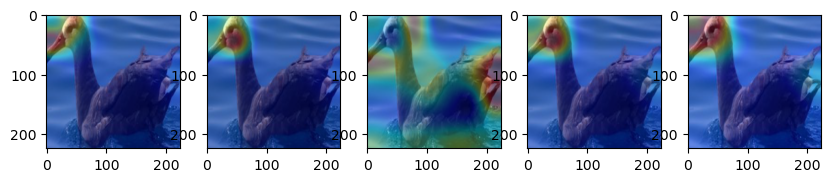

In [99]:
visualize_updated_prototype(a3c.PPnet_multi, 10)

In [28]:
def visualize_img_pattern(p_dir, pid):
    img = skio.imread('./human_comparisons/feedback_images/'+p_dir+'/original_imgs/'+pid+'.png')
    img = sk.img_as_float(img)
    pattern = np.load('./human_comparisons/feedback_images/'+p_dir+'/patterns/'+pid+'.npy')
    heatmap = cv2.applyColorMap(np.uint8(255*pattern), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]
    overlayed_original_img = 2.0 * img[:, :, :3] + 1.0 * heatmap
    overlayed_original_img = overlayed_original_img - np.amin(overlayed_original_img)
    overlayed_original_img = overlayed_original_img / np.amax(overlayed_original_img)
    plt.imshow(overlayed_original_img)

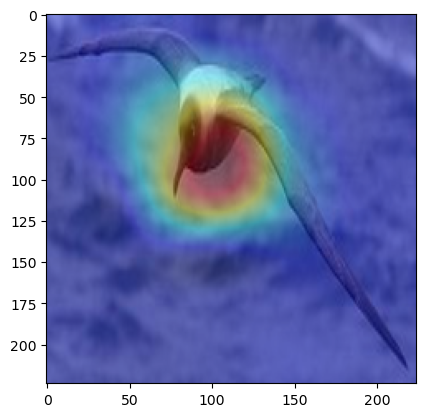

In [29]:
visualize_img_pattern('k=1_random', '89_0')

In [29]:
acc = tnt.test(model=a3c.PPnet_multi, dataloader=test_loader, class_specific=True, log=print)

	test


58it [00:45,  1.26it/s]


	time: 	46.16942882537842
	cross ent: 	7.195334227948353
	cluster: 	4.64465587843081
	separation:	0.0867374726924403
	avg separation:	9.372501044437803
	accu: 		15.878494994822228%
	l1: 		1273.353515625
	p dist pair: 	6.52275276184082
